# BPTT (backpropagation through time)

## モデルの定義

ライブラリの読み込み．

In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using Random, ProgressMeter, PyPlot

In [2]:
f(x) = tanh(x)
df(x) = 1 - tanh(x)^2;

In [3]:
@kwdef struct RNNParameter{FT}
    dt::FT = 1 # time step (ms)
    τ::FT = 10 # time constant (ms)
    α::FT = dt / τ 
    η::FT = 1e-2 # learning rate
end

`w_in`は入力層から再帰層への重み，`w_rec`は再帰重み，`w_out`は出力重みである．

In [4]:
@kwdef mutable struct RNN{FT}
    param::RNNParameter = RNNParameter{FT}()
    
    n_batch::UInt32 # batch size
    n_in::UInt32 # number of input units
    n_rec::UInt32 # number of recurrent units
    n_out::UInt32 # number of output units
    
    h0::Array{FT} = zeros(n_batch, n_rec) # initial state of recurrent units

    # weights
    w_in::Array{FT} = 0.1*(rand(n_in, n_rec) .- 1)
    w_rec::Array{FT} = 1.5*randn(n_rec, n_rec)/sqrt(n_rec)
    w_out::Array{FT} = 0.1*(2*rand(n_rec, n_out) .- 1)/sqrt(n_rec)
    bias::Array{FT} = zeros(1, n_rec)
    
    # changes to weights
    dw_in::Array{FT} = zero(w_in)
    dw_rec::Array{FT} = zero(w_rec)
    dw_out::Array{FT} = zero(w_out)
    dbias::Array{FT} = zero(bias)
end

## 7.9.2 更新関数の定義

In [5]:
function update!(variable::RNN, param::RNNParameter, x::Array, y::Array, training::Bool)
    @unpack n_batch, n_in, n_rec, n_out, h0, w_in, w_rec, w_out, bias, dw_in, dw_rec, dw_out, dbias = variable 
    @unpack dt, τ, α, η = param

    t_max = size(x)[2]  # number of timesteps
    u, h = zeros(n_batch, t_max, n_rec), zeros(n_batch, t_max, n_rec) # input (feedforward + recurrent), time-dependent RNN activity vector
    h[:, 1, :] = h0  # initial state

    ŷ = zeros(n_batch, t_max, n_out)  # RNN output
    error = zeros(n_batch, t_max, n_out)  # readout error

    for t in 1:t_max-1
        u[:, t+1, :] = h[:, t, :] * w_rec + x[:, t+1, :] * w_in .+ bias
        h[:, t+1, :] = h[:, t, :] + α * (-h[:, t, :] + f.(u[:, t+1, :]))
        ŷ[:, t+1, :] = h[:, t+1, :] * w_out 
        error[:, t+1, :] = y[:, t+1, :] - ŷ[:, t+1, :]  # readout error
    end
    
    
    # backward
    if training 
        z = zero(h)
        z[:, end, :] = error[:, end, :] * w_out' 

        for t in t_max:-1:1
            zu = z[:, t, :] .* df.(u[:, t, :])
            if t ≥ 2
                z[:, t-1, :] = z[:, t, :] * (1 - α) + error[:, t, :] * w_out' + zu * w_rec * α
                dw_rec[:, :] += h[:, t-1, :]' * zu
            end

            # Updates  Δweights:
            dw_out[:, :] += h[:, t, :]' * error[:, t, :]
            dw_in[:, :]  += x[:, t, :]' * zu
            dbias[:, :] .+= sum(zu)
        end
        
        # update weights
        w_out[:, :] += η / t_max * dw_out
        w_rec[:, :] += η / t_max * α * dw_rec
        w_in[:, :]  += η / t_max * α * dw_in
        bias[:, :]  += η / t_max * α * dbias
        
        # reset
        dw_in[:, :]  = zero(w_in)
        dw_rec[:, :] = zero(w_rec)
        dw_out[:, :] = zero(w_out)
        dbias[:, :]  = zero(bias)
    end

    return error, ŷ, h
end

update! (generic function with 1 method)

## 正弦波の学習
例として正弦波を出力するRNNを考える．入力1,中間64, 出力2のRNNである．

In [6]:
nt = 100  # number of timesteps in one period
n_batch = 1 # batch size
n_in = 1 # number of inputs
n_out = 2 # number of outputs

begin_input = 0 # begin time steps of input
end_input = 30  # end time steps of input

tsteps = 0:nt-1　# array of time steps
x = ones(n_batch) * (begin_input .≤ tsteps .≤ end_input)'  # input array

y = zeros(n_batch, nt, n_out) # target array
y[:, begin_input+1:end, 1] = sin.(tsteps[1:end-begin_input]*0.1)
y[:, begin_input+1:end, 2] = sin.(tsteps[1:end-begin_input]*0.2)

n_epoch = 25000 # number of epoch
error_arr = zeros(Float32, n_epoch); # memory array of each epoch error

入力と訓練データの確認をする．

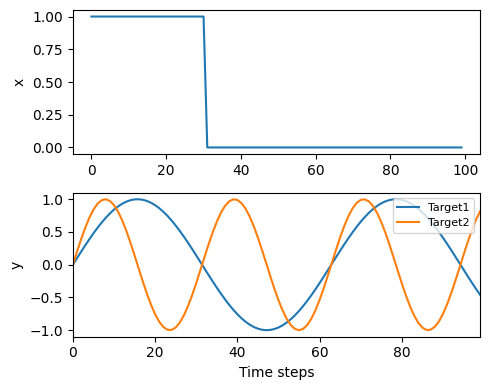

In [7]:
figure(figsize=(5, 4))
subplot(2,1,1); plot(x[1, :]); ylabel("x")
subplot(2,1,2); plot(tsteps, y[1, :, 1], label="Target1"); plot(tsteps, y[1, :, 2], label="Target2")
xlabel("Time steps"); ylabel("y"); xlim(0, tsteps[end])
legend(loc="upper right", fontsize=8)
tight_layout()

モデルの定義をする．

In [8]:
rnn = RNN{Float32}(n_batch=n_batch, n_in=n_in, n_rec=32, n_out=n_out);

学習を実行する．

In [9]:
@showprogress "Training..." for e in 1:n_epoch
    error, ŷ, h = update!(rnn, rnn.param, x, y, true)
    error_arr[e] = sum(error .^ 2)
end

Training...  0%|█                                       |  ETA: 1 days, 4:37:51

Training...  1%|█                                       |  ETA: 0:13:36

Training...  1%|█                                       |  ETA: 0:11:27

Training...  1%|█                                       |  ETA: 0:09:56

Training...  1%|█                                       |  ETA: 0:08:47

Training...  1%|█                                       |  ETA: 0:07:55

Training...  1%|█                                       |  ETA: 0:07:13

Training...  1%|█                                       |  ETA: 0:06:38

Training...  2%|█                                       |  ETA: 0:06:12

Training...  2%|█                                       |  ETA: 0:05:49

Training...  2%|█                                       |  ETA: 0:05:28

Training...  2%|█                                       |  ETA: 0:05:10

Training...  2%|█                                       |  ETA: 0:04:55

Training...  2%|█                                       |  ETA: 0:04:41

Training...  2%|█                                       |  ETA: 0:04:30

Training...  2%|█                                       |  ETA: 0:04:19

Training...  3%|██                                      |  ETA: 0:04:09

Training...  3%|██                                      |  ETA: 0:04:00

Training...  3%|██                                      |  ETA: 0:03:53

Training...  3%|██                                      |  ETA: 0:03:46

Training...  3%|██                                      |  ETA: 0:03:39

Training...  3%|██                                      |  ETA: 0:03:33

Training...  3%|██                                      |  ETA: 0:03:27

Training...  3%|██                                      |  ETA: 0:03:22

Training...  4%|██                                      |  ETA: 0:03:17

Training...  4%|██                                      |  ETA: 0:03:13

Training...  4%|██                                      |  ETA: 0:03:08

Training...  4%|██                                      |  ETA: 0:03:05

Training...  4%|██                                      |  ETA: 0:03:01

Training...  4%|██                                      |  ETA: 0:02:58

Training...  4%|██                                      |  ETA: 0:02:54

Training...  5%|██                                      |  ETA: 0:02:51

Training...  5%|██                                      |  ETA: 0:02:48

Training...  5%|██                                      |  ETA: 0:02:45

Training...  5%|██                                      |  ETA: 0:02:43

Training...  5%|███                                     |  ETA: 0:02:40

Training...  5%|███                                     |  ETA: 0:02:37

Training...  5%|███                                     |  ETA: 0:02:34

Training...  5%|███                                     |  ETA: 0:02:31

Training...  6%|███                                     |  ETA: 0:02:28

Training...  6%|███                                     |  ETA: 0:02:26

Training...  6%|███                                     |  ETA: 0:02:24

Training...  6%|███                                     |  ETA: 0:02:21

Training...  6%|███                                     |  ETA: 0:02:19

Training...  6%|███                                     |  ETA: 0:02:16

Training...  7%|███                                     |  ETA: 0:02:14

Training...  7%|███                                     |  ETA: 0:02:12

Training...  7%|███                                     |  ETA: 0:02:10

Training...  7%|███                                     |  ETA: 0:02:07

Training...  7%|███                                     |  ETA: 0:02:05

Training...  8%|████                                    |  ETA: 0:02:03

Training...  8%|████                                    |  ETA: 0:02:01

Training...  8%|████                                    |  ETA: 0:01:58

Training...  8%|████                                    |  ETA: 0:01:56

Training...  8%|████                                    |  ETA: 0:01:54

Training...  9%|████                                    |  ETA: 0:01:52

Training...  9%|████                                    |  ETA: 0:01:50

Training...  9%|████                                    |  ETA: 0:01:48

Training...  9%|████                                    |  ETA: 0:01:46

Training...  9%|████                                    |  ETA: 0:01:45

Training... 10%|████                                    |  ETA: 0:01:43

Training... 10%|████                                    |  ETA: 0:01:42

Training... 10%|█████                                   |  ETA: 0:01:40

Training... 10%|█████                                   |  ETA: 0:01:39

Training... 11%|█████                                   |  ETA: 0:01:37

Training... 11%|█████                                   |  ETA: 0:01:36

Training... 11%|█████                                   |  ETA: 0:01:34

Training... 11%|█████                                   |  ETA: 0:01:33

Training... 11%|█████                                   |  ETA: 0:01:32

Training... 12%|█████                                   |  ETA: 0:01:31

Training... 12%|█████                                   |  ETA: 0:01:29

Training... 12%|█████                                   |  ETA: 0:01:28

Training... 12%|█████                                   |  ETA: 0:01:27

Training... 13%|██████                                  |  ETA: 0:01:26

Training... 13%|██████                                  |  ETA: 0:01:25

Training... 13%|██████                                  |  ETA: 0:01:24

Training... 13%|██████                                  |  ETA: 0:01:23

Training... 14%|██████                                  |  ETA: 0:01:22

Training... 14%|██████                                  |  ETA: 0:01:21

Training... 14%|██████                                  |  ETA: 0:01:20

Training... 14%|██████                                  |  ETA: 0:01:19

Training... 14%|██████                                  |  ETA: 0:01:19

Training... 15%|██████                                  |  ETA: 0:01:18

Training... 15%|██████                                  |  ETA: 0:01:17

Training... 15%|███████                                 |  ETA: 0:01:16

Training... 15%|███████                                 |  ETA: 0:01:15

Training... 15%|███████                                 |  ETA: 0:01:15

Training... 16%|███████                                 |  ETA: 0:01:14

Training... 16%|███████                                 |  ETA: 0:01:13

Training... 16%|███████                                 |  ETA: 0:01:13

Training... 16%|███████                                 |  ETA: 0:01:12

Training... 17%|███████                                 |  ETA: 0:01:11

Training... 17%|███████                                 |  ETA: 0:01:11

Training... 17%|███████                                 |  ETA: 0:01:10

Training... 17%|███████                                 |  ETA: 0:01:10

Training... 17%|███████                                 |  ETA: 0:01:09

Training... 18%|████████                                |  ETA: 0:01:08

Training... 18%|████████                                |  ETA: 0:01:08

Training... 18%|████████                                |  ETA: 0:01:07

Training... 18%|████████                                |  ETA: 0:01:07

Training... 19%|████████                                |  ETA: 0:01:06

Training... 19%|████████                                |  ETA: 0:01:06

Training... 19%|████████                                |  ETA: 0:01:05

Training... 19%|████████                                |  ETA: 0:01:05

Training... 20%|████████                                |  ETA: 0:01:04

Training... 20%|████████                                |  ETA: 0:01:04

Training... 20%|████████                                |  ETA: 0:01:03

Training... 20%|█████████                               |  ETA: 0:01:03

Training... 20%|█████████                               |  ETA: 0:01:02

Training... 21%|█████████                               |  ETA: 0:01:02

Training... 21%|█████████                               |  ETA: 0:01:01

Training... 21%|█████████                               |  ETA: 0:01:01

Training... 21%|█████████                               |  ETA: 0:01:00

Training... 22%|█████████                               |  ETA: 0:01:00

Training... 22%|█████████                               |  ETA: 0:01:00

Training... 22%|█████████                               |  ETA: 0:00:59

Training... 22%|█████████                               |  ETA: 0:00:59

Training... 22%|█████████                               |  ETA: 0:00:58

Training... 23%|██████████                              |  ETA: 0:00:58

Training... 23%|██████████                              |  ETA: 0:00:58

Training... 23%|██████████                              |  ETA: 0:00:57

Training... 23%|██████████                              |  ETA: 0:00:57

Training... 24%|██████████                              |  ETA: 0:00:56

Training... 24%|██████████                              |  ETA: 0:00:56

Training... 24%|██████████                              |  ETA: 0:00:56

Training... 24%|██████████                              |  ETA: 0:00:55

Training... 24%|██████████                              |  ETA: 0:00:55

Training... 25%|██████████                              |  ETA: 0:00:55

Training... 25%|██████████                              |  ETA: 0:00:54

Training... 25%|███████████                             |  ETA: 0:00:54

Training... 25%|███████████                             |  ETA: 0:00:54

Training... 26%|███████████                             |  ETA: 0:00:53

Training... 26%|███████████                             |  ETA: 0:00:53

Training... 26%|███████████                             |  ETA: 0:00:53

Training... 26%|███████████                             |  ETA: 0:00:52

Training... 26%|███████████                             |  ETA: 0:00:52

Training... 27%|███████████                             |  ETA: 0:00:52

Training... 27%|███████████                             |  ETA: 0:00:51

Training... 27%|███████████                             |  ETA: 0:00:51

Training... 27%|███████████                             |  ETA: 0:00:51

Training... 28%|████████████                            |  ETA: 0:00:51

Training... 28%|████████████                            |  ETA: 0:00:50

Training... 28%|████████████                            |  ETA: 0:00:50

Training... 28%|████████████                            |  ETA: 0:00:50

Training... 28%|████████████                            |  ETA: 0:00:49

Training... 29%|████████████                            |  ETA: 0:00:49

Training... 29%|████████████                            |  ETA: 0:00:49

Training... 29%|████████████                            |  ETA: 0:00:49

Training... 29%|████████████                            |  ETA: 0:00:48

Training... 30%|████████████                            |  ETA: 0:00:48

Training... 30%|████████████                            |  ETA: 0:00:48

Training... 30%|████████████                            |  ETA: 0:00:47

Training... 30%|█████████████                           |  ETA: 0:00:47

Training... 30%|█████████████                           |  ETA: 0:00:47

Training... 31%|█████████████                           |  ETA: 0:00:47

Training... 31%|█████████████                           |  ETA: 0:00:46

Training... 31%|█████████████                           |  ETA: 0:00:46

Training... 31%|█████████████                           |  ETA: 0:00:46

Training... 32%|█████████████                           |  ETA: 0:00:46

Training... 32%|█████████████                           |  ETA: 0:00:45

Training... 32%|█████████████                           |  ETA: 0:00:45

Training... 32%|█████████████                           |  ETA: 0:00:45

Training... 32%|█████████████                           |  ETA: 0:00:45

Training... 33%|██████████████                          |  ETA: 0:00:44

Training... 33%|██████████████                          |  ETA: 0:00:44

Training... 33%|██████████████                          |  ETA: 0:00:44

Training... 33%|██████████████                          |  ETA: 0:00:44

Training... 34%|██████████████                          |  ETA: 0:00:43

Training... 34%|██████████████                          |  ETA: 0:00:43

Training... 34%|██████████████                          |  ETA: 0:00:43

Training... 34%|██████████████                          |  ETA: 0:00:43

Training... 34%|██████████████                          |  ETA: 0:00:43

Training... 35%|██████████████                          |  ETA: 0:00:42

Training... 35%|██████████████                          |  ETA: 0:00:42

Training... 35%|███████████████                         |  ETA: 0:00:42

Training... 35%|███████████████                         |  ETA: 0:00:42

Training... 36%|███████████████                         |  ETA: 0:00:41

Training... 36%|███████████████                         |  ETA: 0:00:41

Training... 36%|███████████████                         |  ETA: 0:00:41

Training... 36%|███████████████                         |  ETA: 0:00:41

Training... 36%|███████████████                         |  ETA: 0:00:41

Training... 37%|███████████████                         |  ETA: 0:00:40

Training... 37%|███████████████                         |  ETA: 0:00:40

Training... 37%|███████████████                         |  ETA: 0:00:40

Training... 37%|███████████████                         |  ETA: 0:00:40

Training... 38%|████████████████                        |  ETA: 0:00:40

Training... 38%|████████████████                        |  ETA: 0:00:39

Training... 38%|████████████████                        |  ETA: 0:00:39

Training... 38%|████████████████                        |  ETA: 0:00:39

Training... 38%|████████████████                        |  ETA: 0:00:39

Training... 39%|████████████████                        |  ETA: 0:00:39

Training... 39%|████████████████                        |  ETA: 0:00:38

Training... 39%|████████████████                        |  ETA: 0:00:38

Training... 39%|████████████████                        |  ETA: 0:00:38

Training... 40%|████████████████                        |  ETA: 0:00:38

Training... 40%|████████████████                        |  ETA: 0:00:38

Training... 40%|█████████████████                       |  ETA: 0:00:37

Training... 40%|█████████████████                       |  ETA: 0:00:37

Training... 40%|█████████████████                       |  ETA: 0:00:37

Training... 41%|█████████████████                       |  ETA: 0:00:37

Training... 41%|█████████████████                       |  ETA: 0:00:37

Training... 41%|█████████████████                       |  ETA: 0:00:36

Training... 41%|█████████████████                       |  ETA: 0:00:36

Training... 42%|█████████████████                       |  ETA: 0:00:36

Training... 42%|█████████████████                       |  ETA: 0:00:36

Training... 42%|█████████████████                       |  ETA: 0:00:36

Training... 42%|█████████████████                       |  ETA: 0:00:35

Training... 42%|█████████████████                       |  ETA: 0:00:35

Training... 43%|██████████████████                      |  ETA: 0:00:35

Training... 43%|██████████████████                      |  ETA: 0:00:35

Training... 43%|██████████████████                      |  ETA: 0:00:35

Training... 43%|██████████████████                      |  ETA: 0:00:35

Training... 44%|██████████████████                      |  ETA: 0:00:34

Training... 44%|██████████████████                      |  ETA: 0:00:34

Training... 44%|██████████████████                      |  ETA: 0:00:34

Training... 44%|██████████████████                      |  ETA: 0:00:34

Training... 44%|██████████████████                      |  ETA: 0:00:34

Training... 45%|██████████████████                      |  ETA: 0:00:33

Training... 45%|██████████████████                      |  ETA: 0:00:33

Training... 45%|███████████████████                     |  ETA: 0:00:33

Training... 45%|███████████████████                     |  ETA: 0:00:33

Training... 46%|███████████████████                     |  ETA: 0:00:33

Training... 46%|███████████████████                     |  ETA: 0:00:33

Training... 46%|███████████████████                     |  ETA: 0:00:32

Training... 46%|███████████████████                     |  ETA: 0:00:32

Training... 47%|███████████████████                     |  ETA: 0:00:32

Training... 47%|███████████████████                     |  ETA: 0:00:32

Training... 47%|███████████████████                     |  ETA: 0:00:32

Training... 47%|███████████████████                     |  ETA: 0:00:32

Training... 47%|███████████████████                     |  ETA: 0:00:31

Training... 48%|████████████████████                    |  ETA: 0:00:31

Training... 48%|████████████████████                    |  ETA: 0:00:31

Training... 48%|████████████████████                    |  ETA: 0:00:31

Training... 48%|████████████████████                    |  ETA: 0:00:31

Training... 49%|████████████████████                    |  ETA: 0:00:31

Training... 49%|████████████████████                    |  ETA: 0:00:30

Training... 49%|████████████████████                    |  ETA: 0:00:30

Training... 49%|████████████████████                    |  ETA: 0:00:30

Training... 49%|████████████████████                    |  ETA: 0:00:30

Training... 50%|████████████████████                    |  ETA: 0:00:30

Training... 50%|████████████████████                    |  ETA: 0:00:30

Training... 50%|█████████████████████                   |  ETA: 0:00:29

Training... 50%|█████████████████████                   |  ETA: 0:00:29

Training... 50%|█████████████████████                   |  ETA: 0:00:29

Training... 51%|█████████████████████                   |  ETA: 0:00:29

Training... 51%|█████████████████████                   |  ETA: 0:00:29

Training... 51%|█████████████████████                   |  ETA: 0:00:29

Training... 51%|█████████████████████                   |  ETA: 0:00:29

Training... 52%|█████████████████████                   |  ETA: 0:00:28

Training... 52%|█████████████████████                   |  ETA: 0:00:28

Training... 52%|█████████████████████                   |  ETA: 0:00:28

Training... 52%|█████████████████████                   |  ETA: 0:00:28

Training... 53%|██████████████████████                  |  ETA: 0:00:28

Training... 53%|██████████████████████                  |  ETA: 0:00:28

Training... 53%|██████████████████████                  |  ETA: 0:00:27

Training... 53%|██████████████████████                  |  ETA: 0:00:27

Training... 53%|██████████████████████                  |  ETA: 0:00:27

Training... 54%|██████████████████████                  |  ETA: 0:00:27

Training... 54%|██████████████████████                  |  ETA: 0:00:27

Training... 54%|██████████████████████                  |  ETA: 0:00:27

Training... 54%|██████████████████████                  |  ETA: 0:00:27

Training... 55%|██████████████████████                  |  ETA: 0:00:26

Training... 55%|██████████████████████                  |  ETA: 0:00:26

Training... 55%|██████████████████████                  |  ETA: 0:00:26

Training... 55%|███████████████████████                 |  ETA: 0:00:26

Training... 55%|███████████████████████                 |  ETA: 0:00:26

Training... 56%|███████████████████████                 |  ETA: 0:00:26

Training... 56%|███████████████████████                 |  ETA: 0:00:25

Training... 56%|███████████████████████                 |  ETA: 0:00:25

Training... 56%|███████████████████████                 |  ETA: 0:00:25

Training... 57%|███████████████████████                 |  ETA: 0:00:25

Training... 57%|███████████████████████                 |  ETA: 0:00:25

Training... 57%|███████████████████████                 |  ETA: 0:00:25

Training... 57%|███████████████████████                 |  ETA: 0:00:25

Training... 57%|███████████████████████                 |  ETA: 0:00:24

Training... 58%|████████████████████████                |  ETA: 0:00:24

Training... 58%|████████████████████████                |  ETA: 0:00:24

Training... 58%|████████████████████████                |  ETA: 0:00:24

Training... 58%|████████████████████████                |  ETA: 0:00:24

Training... 59%|████████████████████████                |  ETA: 0:00:24

Training... 59%|████████████████████████                |  ETA: 0:00:24

Training... 59%|████████████████████████                |  ETA: 0:00:23

Training... 59%|████████████████████████                |  ETA: 0:00:23

Training... 59%|████████████████████████                |  ETA: 0:00:23

Training... 60%|████████████████████████                |  ETA: 0:00:23

Training... 60%|████████████████████████                |  ETA: 0:00:23

Training... 60%|█████████████████████████               |  ETA: 0:00:23

Training... 60%|█████████████████████████               |  ETA: 0:00:23

Training... 61%|█████████████████████████               |  ETA: 0:00:22

Training... 61%|█████████████████████████               |  ETA: 0:00:22

Training... 61%|█████████████████████████               |  ETA: 0:00:22

Training... 61%|█████████████████████████               |  ETA: 0:00:22

Training... 61%|█████████████████████████               |  ETA: 0:00:22

Training... 62%|█████████████████████████               |  ETA: 0:00:22

Training... 62%|█████████████████████████               |  ETA: 0:00:22

Training... 62%|█████████████████████████               |  ETA: 0:00:21

Training... 62%|█████████████████████████               |  ETA: 0:00:21

Training... 63%|██████████████████████████              |  ETA: 0:00:21

Training... 63%|██████████████████████████              |  ETA: 0:00:21

Training... 63%|██████████████████████████              |  ETA: 0:00:21

Training... 63%|██████████████████████████              |  ETA: 0:00:21

Training... 63%|██████████████████████████              |  ETA: 0:00:21

Training... 64%|██████████████████████████              |  ETA: 0:00:20

Training... 64%|██████████████████████████              |  ETA: 0:00:20

Training... 64%|██████████████████████████              |  ETA: 0:00:20

Training... 64%|██████████████████████████              |  ETA: 0:00:20

Training... 65%|██████████████████████████              |  ETA: 0:00:20

Training... 65%|██████████████████████████              |  ETA: 0:00:20

Training... 65%|███████████████████████████             |  ETA: 0:00:20

Training... 65%|███████████████████████████             |  ETA: 0:00:19

Training... 66%|███████████████████████████             |  ETA: 0:00:19

Training... 66%|███████████████████████████             |  ETA: 0:00:19

Training... 66%|███████████████████████████             |  ETA: 0:00:19

Training... 66%|███████████████████████████             |  ETA: 0:00:19

Training... 66%|███████████████████████████             |  ETA: 0:00:19

Training... 67%|███████████████████████████             |  ETA: 0:00:19

Training... 67%|███████████████████████████             |  ETA: 0:00:19

Training... 67%|███████████████████████████             |  ETA: 0:00:18

Training... 67%|███████████████████████████             |  ETA: 0:00:18

Training... 67%|███████████████████████████             |  ETA: 0:00:18

Training... 68%|████████████████████████████            |  ETA: 0:00:18

Training... 68%|████████████████████████████            |  ETA: 0:00:18

Training... 68%|████████████████████████████            |  ETA: 0:00:18

Training... 68%|████████████████████████████            |  ETA: 0:00:18

Training... 69%|████████████████████████████            |  ETA: 0:00:17

Training... 69%|████████████████████████████            |  ETA: 0:00:17

Training... 69%|████████████████████████████            |  ETA: 0:00:17

Training... 69%|████████████████████████████            |  ETA: 0:00:17

Training... 69%|████████████████████████████            |  ETA: 0:00:17

Training... 70%|████████████████████████████            |  ETA: 0:00:17

Training... 70%|████████████████████████████            |  ETA: 0:00:17

Training... 70%|█████████████████████████████           |  ETA: 0:00:17

Training... 70%|█████████████████████████████           |  ETA: 0:00:16

Training... 71%|█████████████████████████████           |  ETA: 0:00:16

Training... 71%|█████████████████████████████           |  ETA: 0:00:16

Training... 71%|█████████████████████████████           |  ETA: 0:00:16

Training... 71%|█████████████████████████████           |  ETA: 0:00:16

Training... 72%|█████████████████████████████           |  ETA: 0:00:16

Training... 72%|█████████████████████████████           |  ETA: 0:00:16

Training... 72%|█████████████████████████████           |  ETA: 0:00:15

Training... 72%|█████████████████████████████           |  ETA: 0:00:15

Training... 72%|█████████████████████████████           |  ETA: 0:00:15

Training... 73%|██████████████████████████████          |  ETA: 0:00:15

Training... 73%|██████████████████████████████          |  ETA: 0:00:15

Training... 73%|██████████████████████████████          |  ETA: 0:00:15

Training... 73%|██████████████████████████████          |  ETA: 0:00:15

Training... 74%|██████████████████████████████          |  ETA: 0:00:15

Training... 74%|██████████████████████████████          |  ETA: 0:00:14

Training... 74%|██████████████████████████████          |  ETA: 0:00:14

Training... 74%|██████████████████████████████          |  ETA: 0:00:14

Training... 74%|██████████████████████████████          |  ETA: 0:00:14

Training... 75%|██████████████████████████████          |  ETA: 0:00:14

Training... 75%|██████████████████████████████          |  ETA: 0:00:14

Training... 75%|███████████████████████████████         |  ETA: 0:00:14

Training... 75%|███████████████████████████████         |  ETA: 0:00:14

Training... 76%|███████████████████████████████         |  ETA: 0:00:13

Training... 76%|███████████████████████████████         |  ETA: 0:00:13

Training... 76%|███████████████████████████████         |  ETA: 0:00:13

Training... 76%|███████████████████████████████         |  ETA: 0:00:13

Training... 76%|███████████████████████████████         |  ETA: 0:00:13

Training... 77%|███████████████████████████████         |  ETA: 0:00:13

Training... 77%|███████████████████████████████         |  ETA: 0:00:13

Training... 77%|███████████████████████████████         |  ETA: 0:00:12

Training... 77%|███████████████████████████████         |  ETA: 0:00:12

Training... 78%|████████████████████████████████        |  ETA: 0:00:12

Training... 78%|████████████████████████████████        |  ETA: 0:00:12

Training... 78%|████████████████████████████████        |  ETA: 0:00:12

Training... 78%|████████████████████████████████        |  ETA: 0:00:12

Training... 78%|████████████████████████████████        |  ETA: 0:00:12

Training... 79%|████████████████████████████████        |  ETA: 0:00:12

Training... 79%|████████████████████████████████        |  ETA: 0:00:11

Training... 79%|████████████████████████████████        |  ETA: 0:00:11

Training... 79%|████████████████████████████████        |  ETA: 0:00:11

Training... 80%|████████████████████████████████        |  ETA: 0:00:11

Training... 80%|████████████████████████████████        |  ETA: 0:00:11

Training... 80%|█████████████████████████████████       |  ETA: 0:00:11

Training... 80%|█████████████████████████████████       |  ETA: 0:00:11

Training... 80%|█████████████████████████████████       |  ETA: 0:00:11

Training... 81%|█████████████████████████████████       |  ETA: 0:00:10

Training... 81%|█████████████████████████████████       |  ETA: 0:00:10

Training... 81%|█████████████████████████████████       |  ETA: 0:00:10[39

Training... 81%|█████████████████████████████████       |  ETA: 0:00:10

Training... 82%|█████████████████████████████████       |  ETA: 0:00:10

Training... 82%|█████████████████████████████████       |  ETA: 0:00:10

Training... 82%|█████████████████████████████████       |  ETA: 0:00:10

Training... 82%|█████████████████████████████████       |  ETA: 0:00:10

Training... 82%|██████████████████████████████████      |  ETA: 0:00:09

Training... 83%|██████████████████████████████████      |  ETA: 0:00:09

Training... 83%|██████████████████████████████████      |  ETA: 0:00:09

Training... 83%|██████████████████████████████████      |  ETA: 0:00:09

Training... 83%|██████████████████████████████████      |  ETA: 0:00:09

Training... 84%|██████████████████████████████████      |  ETA: 0:00:09

Training... 84%|██████████████████████████████████      |  ETA: 0:00:09

Training... 84%|██████████████████████████████████      |  ETA: 0:00:09

Training... 84%|██████████████████████████████████      |  ETA: 0:00:08

Training... 84%|██████████████████████████████████      |  ETA: 0:00:08

Training... 85%|██████████████████████████████████      |  ETA: 0:00:08

Training... 85%|██████████████████████████████████      |  ETA: 0:00:08

Training... 85%|███████████████████████████████████     |  ETA: 0:00:08

Training... 85%|███████████████████████████████████     |  ETA: 0:00:08

Training... 86%|███████████████████████████████████     |  ETA: 0:00:08

Training... 86%|███████████████████████████████████     |  ETA: 0:00:08

Training... 86%|███████████████████████████████████     |  ETA: 0:00:07

Training... 86%|███████████████████████████████████     |  ETA: 0:00:07

Training... 86%|███████████████████████████████████     |  ETA: 0:00:07

Training... 87%|███████████████████████████████████     |  ETA: 0:00:07

Training... 87%|███████████████████████████████████     |  ETA: 0:00:07

Training... 87%|███████████████████████████████████     |  ETA: 0:00:07

Training... 87%|███████████████████████████████████     |  ETA: 0:00:07

Training... 88%|████████████████████████████████████    |  ETA: 0:00:07

Training... 88%|████████████████████████████████████    |  ETA: 0:00:07

Training... 88%|████████████████████████████████████    |  ETA: 0:00:06

Training... 88%|████████████████████████████████████    |  ETA: 0:00:06

Training... 89%|████████████████████████████████████    |  ETA: 0:00:06

Training... 89%|████████████████████████████████████    |  ETA: 0:00:06

Training... 89%|████████████████████████████████████    |  ETA: 0:00:06

Training... 89%|████████████████████████████████████    |  ETA: 0:00:06

Training... 89%|████████████████████████████████████    |  ETA: 0:00:06

Training... 90%|████████████████████████████████████    |  ETA: 0:00:06

Training... 90%|████████████████████████████████████    |  ETA: 0:00:05

Training... 90%|█████████████████████████████████████   |  ETA: 0:00:05

Training... 90%|█████████████████████████████████████   |  ETA: 0:00:05

Training... 91%|█████████████████████████████████████   |  ETA: 0:00:05

Training... 91%|█████████████████████████████████████   |  ETA: 0:00:05

Training... 91%|█████████████████████████████████████   |  ETA: 0:00:05

Training... 91%|█████████████████████████████████████   |  ETA: 0:00:05

Training... 91%|█████████████████████████████████████   |  ETA: 0:00:05

Training... 92%|█████████████████████████████████████   |  ETA: 0:00:04

Training... 92%|█████████████████████████████████████   |  ETA: 0:00:04

Training... 92%|█████████████████████████████████████   |  ETA: 0:00:04

Training... 92%|█████████████████████████████████████   |  ETA: 0:00:04

Training... 93%|██████████████████████████████████████  |  ETA: 0:00:04

Training... 93%|██████████████████████████████████████  |  ETA: 0:00:04

Training... 93%|██████████████████████████████████████  |  ETA: 0:00:04

Training... 93%|██████████████████████████████████████  |  ETA: 0:00:04

Training... 93%|██████████████████████████████████████  |  ETA: 0:00:03

Training... 94%|██████████████████████████████████████  |  ETA: 0:00:03

Training... 94%|██████████████████████████████████████  |  ETA: 0:00:03

Training... 94%|██████████████████████████████████████  |  ETA: 0:00:03

Training... 94%|██████████████████████████████████████  |  ETA: 0:00:03

Training... 95%|██████████████████████████████████████  |  ETA: 0:00:03

Training... 95%|██████████████████████████████████████  |  ETA: 0:00:03

Training... 95%|██████████████████████████████████████  |  ETA: 0:00:03

Training... 95%|███████████████████████████████████████ |  ETA: 0:00:03

Training... 95%|███████████████████████████████████████ |  ETA: 0:00:02

Training... 96%|███████████████████████████████████████ |  ETA: 0:00:02

Training... 96%|███████████████████████████████████████ |  ETA: 0:00:02

Training... 96%|███████████████████████████████████████ |  ETA: 0:00:02

Training... 96%|███████████████████████████████████████ |  ETA: 0:00:02

Training... 97%|███████████████████████████████████████ |  ETA: 0:00:02

Training... 97%|███████████████████████████████████████ |  ETA: 0:00:02

Training... 97%|███████████████████████████████████████ |  ETA: 0:00:02

Training... 97%|███████████████████████████████████████ |  ETA: 0:00:01

Training... 97%|███████████████████████████████████████ |  ETA: 0:00:01

Training... 98%|████████████████████████████████████████|  ETA: 0:00:01

Training... 98%|████████████████████████████████████████|  ETA: 0:00:01

Training... 98%|████████████████████████████████████████|  ETA: 0:00:01

Training... 98%|████████████████████████████████████████|  ETA: 0:00:01

Training... 99%|████████████████████████████████████████|  ETA: 0:00:01

Training... 99%|████████████████████████████████████████|  ETA: 0:00:01

Training... 99%|████████████████████████████████████████|  ETA: 0:00:01

Training... 99%|████████████████████████████████████████|  ETA: 0:00:00

Training... 99%|████████████████████████████████████████|  ETA: 0:00:00

Training...100%|████████████████████████████████████████|  ETA: 0:00:00

Training...100%|████████████████████████████████████████|  ETA: 0:00:00

Training...100%|████████████████████████████████████████| Time: 0:00:52


損失の推移を確認する．

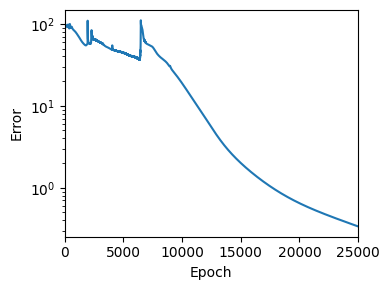

In [10]:
figure(figsize=(4,3))
semilogy(error_arr); ylabel("Error"); xlabel("Epoch"); xlim(0, n_epoch)
tight_layout()

## 学習後の出力の確認

In [11]:
error, ŷ, h = update!(rnn, rnn.param, x, y, false)
println("Error : ", sum(error.^2))

Error : 

0.33795359873543784


見やすいように出力のピークに応じて中間層のユニットをソートする．

In [12]:
max_idx = Tuple.(argmax(h[1, :, :]', dims=2))
h_ = h[1, :, sortperm(last.(max_idx)[:, 1])];

出力層，中間層の出力を描画する．

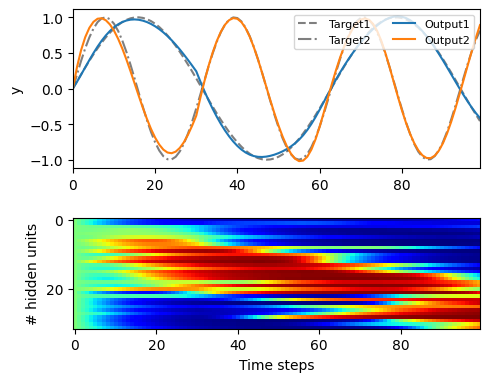

In [13]:
figure(figsize=(5, 4))
subplot(2,1,1)
plot(tsteps, y[1, :, 1], "--k", alpha=.5, label="Target1")
plot(tsteps, y[1, :, 2], "-.k", alpha=.5, label="Target2")
plot(tsteps, ŷ[1, :, 1], label="Output1")
plot(tsteps, ŷ[1, :, 2], label="Output2")
ylabel("y"); xlim(0, tsteps[end])
legend(loc="upper right", ncol=2, fontsize=8)

subplot(2,1,2)
imshow(h_', cmap="jet", aspect=0.85)
xlabel("Time steps"); ylabel("# hidden units")

tight_layout()